# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \boldsymbol{S}^\top \mathcal{C} (\boldsymbol{b})^\top ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $


In [4]:
from ipynb.fs.full.deblurring_gradients import full_grad , stoch_grad, get_batch

In [5]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy.linalg import circulant

In [7]:
np.random.seed(0)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
blur_path="./"
image_list = sorted(os.listdir(data_path))
blur_list = sorted(os.listdir(blur_path))

# set image and blurring kernel size
H = 64
W = 64

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
ORIG = Image.open(data_path + image_list[8]).resize((H,W))
ORIG = np.array(ORIG) / 255.0
mintmp = np.min(ORIG)
maxtmp = np.max(ORIG)
ORIG = (ORIG - mintmp) / (maxtmp - mintmp)

## Read blurring kernel
blur = Image.open(blur_path + blur_list[2]).resize((H,W))

(-0.5, 63.5, 63.5, -0.5)

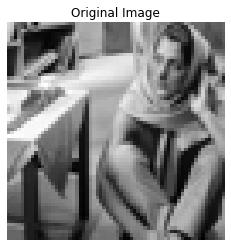

In [8]:
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

(-0.5, 63.5, 63.5, -0.5)

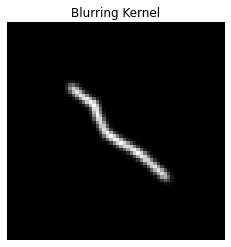

In [9]:
blur_fig = plt.figure()
ax = blur_fig.add_subplot(1, 1, 1)
blur_plot = plt.imshow(blur, cmap='gray')
ax.set_title('Blurring Kernel')
ax.axis('off')

In [10]:
## Set signal model parameters
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 5							# noise level of measurements

## Create noise
noises = np.random.normal(0, sigma, (N,))

## Create cirulant matrix
vb = np.matrix.flatten(np.asarray(blur)) # flatten blurring kernel into a vector
Cb = circulant(vb) # create circulant matrix of v_b

## Precompute Cb_inv leveraging properties of circulant matrices
fvb = np.fft.fft(vb) # compute dft of vb
Dvb = np.diag(1 / fvb) # create diag matrix of reciprocal of fvb
Cb_inv = np.real(np.fft.fft2(Dvb)) / H / W # take 2D DFT of Dvb, ignore (small) imag component

## Vectorize orig image
vorig = np.matrix.flatten(np.asarray(ORIG))

# Test problem without subsampling for sanity checking of problem formulation

Expected results: no noise --> perfect recovery

In [11]:
# ## Create measurements
# y = np.matmul(Cb, vorig)

# # Visualize blurry measurements
# mintmp = np.min(y)
# maxtmp = np.max(y)
# y = (y - mintmp) / (maxtmp - mintmp)

# blurred_fig = plt.figure()
# ax = blurred_fig.add_subplot(1, 1, 1)
# blurred_plot = plt.imshow(np.flip(y.reshape((H,W))), cmap='gray', vmin=0, vmax=1)
# ax.set_title('Measurements')
# ax.axis('off')

# ## compute x = Cb_inv * y
# x_init = np.flip(Cb_inv.dot(y))
# mintmp = np.min(x_init)
# maxtmp = np.max(x_init)
# x_init = (x_init - mintmp) / (maxtmp - mintmp)
# x = np.copy(x_init)

# init_fig = plt.figure()
# ax = init_fig.add_subplot(1, 1, 1)
# init_plot = plt.imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
# ax.set_title('Recovered Image')
# ax.axis('off')

# print(x_init - vorig)

# Introduce subsampled image deblurring problem

In [12]:
## Create noisy measurements
s = 2 # subsampling rate
y0 = np.matmul(Cb, vorig) + noises
y = y0[::s]
y_zpad = np.zeros((N,))
y_zpad[::s] = y0[::s] # zero pad for visualization

In [13]:
## Precompute essential matrices
idx = np.arange(0, H*W, s)
S_Cb = Cb[idx,:]
S_Cb_pinv = np.linalg.pinv(S_Cb)
V_2 = np.transpose(S_Cb)
V_1 = V_2.dot(S_Cb)
L = np.linalg.norm(V_1, 'f')

one
one
one
one
one


(-0.5, 63.5, 63.5, -0.5)

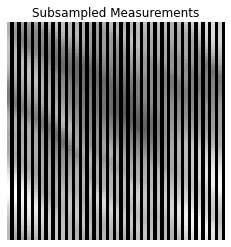

In [14]:
# Visualize blurry measurements with zero-padding
mintmp = np.min(y_zpad)
maxtmp = np.max(y_zpad)
y_zpad = (y_zpad - mintmp) / (maxtmp - mintmp)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = plt.imshow(y_zpad.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
ax.set_title('Subsampled Measurements')
ax.axis('off')

(-0.5, 63.5, 63.5, -0.5)

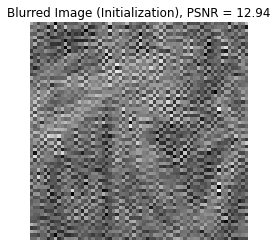

In [15]:
## Visualize naive initialization
x_init = S_Cb_pinv.dot(y)
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)

init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Blurred Image (Initialization), PSNR = {peak_signal_noise_ratio(x_init.reshape((H,W)), ORIG):0.2f}')
ax.axis('off')

In [41]:
def PnP_SVRG_Deblur(z, SCb, V1, V2, meas, eta, T1, T2, batch_size, FILTER, patch, orig):
    H, W = orig.shape[:2]
    time_per_iter = []
    psnr_per_iter = []
    t0 = 0

    ## Main PnP SVRG routine
    for i in range(T_outer):
        ## outer loop
        mu = np.real(full_grad(z, meas, V1, V2))	# Average gradient
        w = np.copy(z) 					# reference point
        start_iter = time.time()
        for j in range(T_inner):
            ## inner loop
            # prep matrices for batch
            BAT = np.random.choice(meas.size, batch_size, replace=False)

            W1 = np.zeros(SCb.shape[:2])
            W1[BAT,:] = SCb[BAT,:]

            meas_bat = np.zeros(SCb.shape[0])
            meas_bat[BAT] = meas[BAT]

            # stoch grad update
            start_grad = time.time()

            v = stoch_grad(z, meas_bat, W1, V2) - stoch_grad(w, meas_bat, W1, V2) + mu
            z = z - eta / (t0 + 1)*v

            # Denoising
            ztilde = np.copy(z)
            mintmp = np.min(ztilde)
            maxtmp = np.max(ztilde)
            ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

            # denoise
            z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
            print(str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))
            z = np.matrix.flatten(z)
        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z.reshape(H,W)))

        t0 += 1
    return z, time_per_iter, psnr_per_iter

In [42]:
## Run PnP-SVRG
T_outer = 10 				# Number of outer loop iterations
T_inner = 2 				# Number of inner loop iterations
eta_SVRG = .01				# step size for SVRG
batch_size_SVRG=100
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_Deblur(x_init, S_Cb, V_1, V_2, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)


0 0 13.263124023895362
0 1 13.217694271434024
1 0 13.149362660616202
1 1 13.150241868285061
2 0 13.141529626840281
2 1 13.141530073353618
3 0 13.138791642215935
3 1 13.138534906969983
4 0 13.136633637391055
4 1 13.136399727736476
5 0 13.134622426229258
5 1 13.134359573565318
6 0 13.132651732850837
6 1 13.132368630932692
7 0 13.130715804757036
7 1 13.130401601731943
8 0 13.1288037937808
8 1 13.12850785879338
9 0 13.12695510493353
9 1 13.126615291650236


(-0.5, 63.5, 63.5, -0.5)

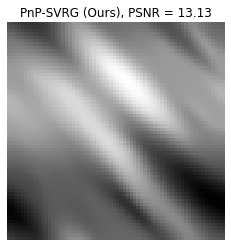

In [43]:
psnr_output_SVRG = peak_signal_noise_ratio(ORIG, output_SVRG.reshape(H,W))
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(output_SVRG.reshape(H,W), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

In [26]:
def PnP_GD_Deblur(z, SCb, V1, V2, meas, eta, T, FILTER, patch, orig):
    time_per_iter = []
    psnr_per_iter = []

    print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, z.reshape([H,W]))))
    t1 = 0
    # Main PnP GD routine
    for i in range(T):
        start_iter = time.time()
        full_grad(z, meas, V1, V2)
        # Update variables
        v = np.real(full_grad(z, meas, V1, V2))
        z = z - eta / (t1**2 + 1) * v

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))

        # Denoising
        ztilde = np.copy(z)

        # rescale
        mintmp = np.min(ztilde)
        maxtmp = np.max(ztilde)
        ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

        z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()

        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t1 += 1
        z = np.matrix.flatten(z)
    return z, time_per_iter, psnr_per_iter

In [27]:
T_GD = 10
eta_GD = 1 / L
NLM_filter = .015

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_GD, time_per_iter_GD, psnr_per_iter_GD = PnP_GD_Deblur(x_init, S_Cb, V_1, V_2, y, eta_GD, T_GD, NLM_filter, patch_kw, ORIG)

Initial PSNR = 12.93743779159147
0 13.00868904186215
0 12.974255453185336
1 13.00980580437826
1 12.992124938211692
2 13.006426663058807
2 12.999172763036249
3 13.006319992484825
3 13.002677066086552
4 13.00687510573984
4 13.004733617705373
5 13.00747463197492
5 13.006077285122423
6 13.00800112947141
6 13.00702168891991
7 13.008443952959261
7 13.00772117727349
8 13.008814352404572
8 13.0082600285713
9 13.009125993947212
9 13.00868798677563
10 13.009390654728554
10 13.009036249037793
11 13.009617689335931
11 13.009325347645246
12 13.009814359570557
12 13.009569337128974
13 13.009986287687802
13 13.00977815644992
14 13.010137849934635
14 13.009959029640738
15 13.010272482078218
15 13.01011733179044
16 13.010392907940883
16 13.010257143897725
17 13.010501308502215
17 13.01038161947491
18 13.010599447076475
18 13.010493233348202
19 13.010688762500557
19 13.010593954529474
20 13.010770439068143
20 13.010685368861214
21 13.010845459493076
21 13.010768767664873
22 13.010914645405576
22 13.0108

185 13.012484842166195
185 13.01248385219318
186 13.012485892210279
186 13.01248491130869
187 13.012486929562371
187 13.012485957621996
188 13.012487954458667
188 13.012486991370938
189 13.012488967129702
189 13.012488012787657
190 13.012489967800494
190 13.012489022098757
191 13.012490956690703
191 13.01249001952544
192 13.012491934014786
192 13.012491005283701
193 13.012492899982158
193 13.012491979584397
194 13.012493854797256
194 13.012492942633472
195 13.012494798659782
195 13.012493894632026
196 13.012495731764751
196 13.012494835776549
197 13.012496654302716
197 13.012495766258908
198 13.012497566459757
198 13.012496686266575
199 13.01249846841771
199 13.012497595982712
200 13.012499360354237
200 13.012498495586293
201 13.01250024244295
201 13.012499385252223
202 13.012501114853524
202 13.012500265151434
203 13.012501977751793
203 13.012501135451
204 13.012502831299846
204 13.01250199631424
205 13.01250367565615
205 13.012502847900828
206 13.012504510975646
206 13.01250369036686

367 13.012577515139814
367 13.01257724525771
368 13.012577766321986
368 13.012577497908875
369 13.012578016152528
369 13.01257774919664
370 13.012578264642505
370 13.012577999132189
371 13.012578511802868
371 13.012578247726594
372 13.012578757644436
372 13.01257849499079
373 13.012579002177908
373 13.012578740935599
374 13.012579245413871
374 13.012578985571718
375 13.012579487362787
375 13.012579228909729
376 13.01257972803501
376 13.012579470960091
377 13.01257996744077
377 13.01257971173315
378 13.01258020559019
378 13.01257995123914
379 13.012580442493283
379 13.012580189488181
380 13.01258067815995
380 13.012580426490285
381 13.01258091259999
381 13.01258066225535
382 13.012581145823086
382 13.012580896793171
383 13.012581377838824
383 13.012581130113436
384 13.012581608656685
384 13.012581362225726
385 13.01258183828605
385 13.012581593139522
386 13.012582066736194
386 13.012581822864204
387 13.012582294016298
387 13.012582051409048
388 13.012582520135442
388 13.012582278783233


547 13.012608042629259
547 13.01260792173988
548 13.012608156702894
548 13.012608036256918
549 13.01260827036469
549 13.012608150359679
550 13.012608383616872
550 13.012608264050403
551 13.012608496461644
551 13.012608377331317
552 13.012608608901195
552 13.012608490204622
553 13.012608720937704
553 13.012608602672518
554 13.012608832573328
554 13.012608714737173
555 13.012608943810207
555 13.012608826400754
556 13.012609054650472
556 13.012608937665401
557 13.012609165096238
557 13.01260904853325
558 13.012609275149602
558 13.01260915900641
559 13.012609384812645
559 13.012609269086983
560 13.012609494087439
560 13.012609378777055
561 13.012609602976035
561 13.012609488078695
562 13.012609711480474
562 13.012609596993956
563 13.01260981960278
563 13.012609705524882
564 13.012609927344965
564 13.0126098136735
565 13.012610034709024
565 13.012609921441818
566 13.01261014169694
566 13.012610028831839
567 13.012610248310688
567 13.012610135845543
568 13.012610354552212
568 13.012610242484

727 13.01262355204464
727 13.012623483773606
728 13.012623616906158
728 13.012623548823054
729 13.012623681590592
729 13.01262361369464
730 13.012623746098663
730 13.012623678389092
731 13.012623810431093
731 13.012623742907131
732 13.01262387458859
732 13.012623807249478
733 13.012623938571867
733 13.012623871416842
734 13.012624002381635
734 13.012623935409941
735 13.012624066018592
735 13.01262399922948
736 13.012624129483438
736 13.012624062876162
737 13.012624192776874
737 13.012624126350685
738 13.012624255899583
738 13.012624189653748
739 13.012624318852259
739 13.01262425278604
740 13.012624381635586
740 13.01262431574825
741 13.012624444250244
741 13.012624378541064
742 13.012624506696909
742 13.012624441165162
743 13.012624568976253
743 13.012624503621222
744 13.012624631088949
744 13.012624565909917
745 13.012624693035661
745 13.012624628031917
746 13.012624754817054
746 13.012624689987888
747 13.012624816433789
747 13.012624751778494
748 13.012624877886514
748 13.0126248134

907 13.012632931014245
907 13.012632887185816
908 13.012632972764777
908 13.012632929032929
909 13.012633014423693
909 13.012632970788104
910 13.012633055991294
910 13.012633012451648
911 13.012633097467878
911 13.012633054023858
912 13.012633138853744
912 13.012633095505034
913 13.012633180149189
913 13.012633136895477
914 13.012633221354509
914 13.01263317819548
915 13.012633262469997
915 13.012633219405343
916 13.012633303495946
916 13.012633260525357
917 13.012633344432649
917 13.012633301555816
918 13.012633385280395
918 13.012633342497011
919 13.012633426039475
919 13.012633383349234
920 13.012633466710177
920 13.012633424112774
921 13.012633507292783
921 13.01263346478792
922 13.012633547787587
922 13.012633505374955
923 13.012633588194866
923 13.01263354587417
924 13.012633628514907
924 13.012633586285844
925 13.012633668747988
925 13.012633626610263
926 13.012633708894395
926 13.01263366684771
927 13.0126337489544
927 13.012633706998464
928 13.012633788928289
928 13.0126337470

(-0.5, 63.5, 63.5, -0.5)

<Figure size 432x288 with 0 Axes>

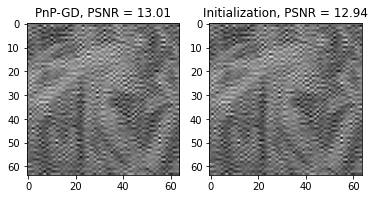

In [30]:
mintmp = np.min(output_GD)
maxtmp = np.max(output_GD)
output_GD = (output_GD - mintmp) / (maxtmp - mintmp)

psnr_output_GD = peak_signal_noise_ratio(ORIG, output_GD.reshape([H,W]))
gd_fig = plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(output_GD.reshape([H,W]), cmap='gray', vmin=0, vmax=1)
axarr[0].set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
axarr[1].imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
axarr[1].set_title(f'Initialization, PSNR = {peak_signal_noise_ratio(x_init.reshape((H,W)), ORIG):0.2f}')
# ax = gd_fig.add_subplot(1, 2, 1)
# gd_plot = plt.imshow(output_GD.reshape([H,W]), cmap='gray', vmin=0, vmax=1)
# ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
# ax = gd_fig.addsubplot(1, 2, 2)
# init_plot = plt.imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
# ax.set_title(f'Blurred Image (Initialization), PSNR = {peak_signal_noise_ratio(x_init.reshape((H,W)), orig):0.2f}')

ax.axis('off')

In [36]:
def PnP_SGD_Deblur(z, SCb, V1, V2, meas, eta, T, batch_size, FILTER, patch, orig):
    time_per_iter = []
    psnr_per_iter = []

    print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))
    t2 = 0
    # Main PnP SGD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        BAT = np.random.choice(meas.size, batch_size, replace=False)

        W1 = np.zeros(SCb.shape[:2])
        W1[BAT,:] = SCb[BAT,:]

        meas_bat = np.zeros(SCb.shape[0])
        meas_bat[BAT] = meas[BAT]

        v = stoch_grad(z, meas_bat, W1, V2)
        z = z - eta * v

        ## Denoising
        ztilde = np.copy(z)

        # rescale
        mintmp = np.min(ztilde)
        maxtmp = np.max(ztilde)
        ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

        z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()

        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z.reshape(H,W)))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))
        t2 += 1
        z = np.matrix.flatten(z)
    return z, time_per_iter, psnr_per_iter

In [38]:
T_SGD = 10
eta_SGD = 1 / L				# step size for GD
batch_size_SGD = 100
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SGD, time_per_iter_SGD, psnr_per_iter_SGD = PnP_SGD_Deblur(x_init, S_Cb, V_1, V_2, y, eta_SGD, T_SGD, batch_size_SGD, \
                                                                 NLM_filter, patch_kw, ORIG)

Initial PSNR = 12.93743779159147
0 12.938752484007876
1 12.939868286570782
2 12.941130169824053
3 12.942010530395414
4 12.943528476119075
5 12.944851787281786
6 12.94621151518366
7 12.948108538828368
8 12.949680186374762
9 12.95110460022731


(-0.5, 63.5, 63.5, -0.5)

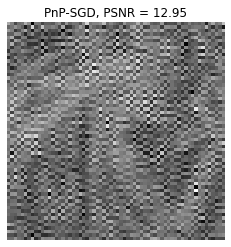

In [40]:
psnr_output_SGD = peak_signal_noise_ratio(ORIG, output_SGD.reshape(H,W))
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD.reshape(H,W), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')

In [ ]:
alpha = 2.0
T_ADMM = 20
NLM_filter = .015			 		 

x = np.copy(x_init)
print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t3 = 0

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_ADMM = []
psnr_per_iter_ADMM = []

v = np.copy(x)
u = np.zeros((H,W), dtype=np.float64)

""" Main loop. """
for i in range(T_ADMM):
	start_iter = time.time()
	xold = np.copy(x)
	vold = np.copy(v)
	uold = np.copy(u)
	""" Update variables. """

	vtilde = np.copy(x+u)
	vf = np.fft.fft2(vtilde)
	La2 = 1.0/2.0/alpha
	vf[index] = (La2 * vf[index] + y[index]) / (1.0 + La2)
	v = np.real(np.fft.ifft2(vf))

	""" Denoising step. """

	xtilde = np.copy(2*v - xold - uold)
	mintmp = np.min(xtilde)
	maxtmp = np.max(xtilde)
	xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

	# the reason for the following scaling:
	# our denoisers are trained with "normalized images + noise"
	# so the scale should be 1 + O(sigma)
	scale_range = 1.0 + sigma/255.0/2.0 
	scale_shift = (1 - scale_range) / 2.0
	xtilde = xtilde * scale_range + scale_shift
	

	# pytorch denoising model
	x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)

	# scale and shift the denoised image back
	x = (x - scale_shift) / scale_range
	x = x * (maxtmp - mintmp) + mintmp

	""" Update variables. """
	u = uold + xold - v
	stop_iter = time.time()

	time_per_iter_ADMM.append(stop_iter-start_iter)
	psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))
	print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
	t3 += 1

output_ADMM = np.copy(x)

In [ ]:
psnr_output_ADMM = peak_signal_noise_ratio(orig, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

In [52]:
def PnP_LSVRG_Deblur(z, SCb, V1, V2, meas, eta, T, batch_size, p, FILTER, patch, orig):
    H, W = orig.shape[:2]
    
    time_per_iter = []
    psnr_per_iter = []

    w = np.copy(z)

    t4 = 0
    zero_mat = np.zeros([H,W])
    # Main PnP SVRG routine
    for i in range(T):
        # Update variables
        BAT = np.random.choice(meas.size, batch_size, replace=False)

        W1 = np.zeros(SCb.shape[:2])
        W1[BAT,:] = SCb[BAT,:]

        meas_bat = np.zeros(SCb.shape[0])
        meas_bat[BAT] = meas[BAT]
        # outer loop
        mu = full_grad(z, meas_bat, V1, V2)   	# Average gradient
        # 	w = np.copy(x) 					# reference point
        start_iter = time.time()

        # inner loop
        start_grad = time.time()
        v = stoch_grad(z, meas_bat, W1, V2) - stoch_grad(w, meas_bat, W1, V2) + mu
        z = z - eta_LSVRG*v

        # Denoising
        ztilde = np.copy(z)

        # rescale
        mintmp = np.min(ztilde)
        maxtmp = np.max(ztilde)
        ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

        # denoise
        z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))

        # update reference point with probability 1-p
        if np.random.random() > p:
            w = np.copy(z)
            w = np.matrix.flatten(w)

        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z.reshape(H,W)))

        t4 += 1
        z = np.matrix.flatten(z)
    return z, time_per_iter, psnr_per_iter

In [54]:
T_LSVRG = 20 				# Number of outer loop iterations
eta_LSVRG = 1 / L				# step size for SVRG
p_LSVRG = .8						# probability of NOT updating reference point
batch_size_LSVRG = 100
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_LSVRG, time_per_iter_LSVRG, psnr_per_iter_LSVRG = PnP_LSVRG_Deblur(x_init, S_Cb, V_1, V_2, y, \
                                                                         eta_LSVRG, T_LSVRG, \
                                                                         batch_size_LSVRG, p_LSVRG, \
                                                                         NLM_filter, patch_kw, ORIG)

0 12.939992480906382
1 12.940560401713658
2 12.941912429423478
3 12.94383677580032
4 12.944689629033594
5 12.945789907605821
6 12.948375562575158
7 12.950556050352402
8 12.953061821048319
9 12.955253655553918
10 12.957224372398501
11 12.95933180250773
12 12.961331920966916
13 12.963657313872229
14 12.965588244067803
15 12.968546555463238
16 12.970949622425515
17 12.974212575582111
18 12.976236813003002
19 12.97902894718943


(-0.5, 63.5, 63.5, -0.5)

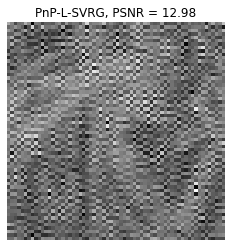

In [56]:
psnr_output_LSVRG = peak_signal_noise_ratio(ORIG, output_LSVRG.reshape(H,W))
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG.reshape(H,W), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

In [ ]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .02						# probability of NOT updating reference point
theta1 = .0001
theta2 = .0001
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=100
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

u = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

W_2 = np.transpose(S_Cb)

t5 = 0
zero_mat = np.zeros([H,W])
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*u
    start_iter = time.time()

    # Update variables
    BAT = np.random.choice(y.size, batch_size_LKatyusha, replace=False)
    print(BAT)
    W_1 = np.zeros(S_Cb.shape[:2])
    W_1[BAT,:] = S_Cb[BAT,:]

    y_bat = np.zeros(S_Cb.shape[0])
    y_bat[BAT] = y[BAT]
    
    start_grad = time.time()
    g = stoch_grad(x, y_bat, W_1, W_2) - stoch_grad(x, y_bat, W_1, W_2) + full_grad(x, y, M_1, M_2)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    u = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # rescale
    mintmp = np.min(wtilde)
    maxtmp = np.max(wtilde)
    wtilde = (wtilde - mintmp) / (maxtmp - mintmp)
    
    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w.reshape(H,W))))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w.reshape(H,W)))

    t5 += 1
    w = np.matrix.flatten(w)
output_LKatyusha = w

In [ ]:
#$ Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()